## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

This is a notebook to investigate the signal coherence of spatial transcriptomics signal in a mouse-brain showcase data set by 10X's Xenium technology.
Signal incoherence can be caused by overlapping cells, the presence of which conflict with a 2D cell segmentation model. 

The analysis is part of a publication by Salas et al. It uses Xenium's show case data set of a mouse brain which can be downloaded on [their web page](https://www.10xgenomics.com/products/xenium-in-situ/mouse-brain-dataset-explorer).

It also uses the ovrlpy python package for signal analysis. ([github](https://github.com/HiDiHlabs/ovrl.py)).
 

In [2]:
%load_ext autoreload
%autoreload 2


#### Basic imports:

In [3]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)

0.00011274497956037521


#### Define parameters

In [4]:
# SSAM vector field resolution:
um_per_pixel = 2.0

# SSAM pandwidth:
bw = 1

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

n_replicate = 1

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'
# data_root = '/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/spatial/'
# filename='ms_brain_multisection1.h5ad'



In [5]:
# adata.uns['spots'].groupby('cell_id').apply(lambda x: x['z_location'].mean())

## Define & load data

####  0: Xenium Mouse brain dataset:

In [6]:

if dataset == 0:
    
    perf_=time.perf_counter()

    adata = anndata.read_h5ad(os.path.join(file_root,
                f'../../../../raw_data/Xenium-benchmark/spatial/ms_brain_multisection{n_replicate}.h5ad'),)



    coords = adata.uns['spots'].copy()
    coords = coords[~(coords.feature_name.str.contains("BLANK") | coords.feature_name.str.contains("NegControl"))]

    df = coords[['x_location' ,'y_location' ,'z_location','feature_name' ]]#,'cell_id','cell_type_louis','cell_id_louis']]

    # replace the feature_name Ccn2 with Ctgf, which is present in the scRNAseq data:
    # df.loc[df.feature_name=='Ccn2','feature_name'] = 'Ctgf'
    df.columns = ['x','y','z','gene' ,]#'cell_id','cell_type_louis','cell_id_louis']
    df = df[~df.gene.str.contains('Blank')][::1]
    df['gene']=df['gene'].astype('category')

    # spot_df = df.copy()
    genes = sorted(df.gene.unique())
    
    print(f'Loading time: {time.perf_counter()-perf_}')
    perf_=time.perf_counter()

del coords,
df.head()


Loading time: 122.17137501668185


,x,y,z,gene
transcript_id,,,,
281474976710664,4843.0460,6427.7300,19.068869,Bhlhe40
281474976710665,4844.6330,6223.1826,18.520160,Parm1
281474976710667,4842.9434,6478.3105,18.500109,Bhlhe40
281474976710669,4843.9414,6344.5503,15.016154,Lyz2
281474976710670,4843.1626,6632.1120,15.394680,Dkk3


Pre-processing time: 2.631709053181112


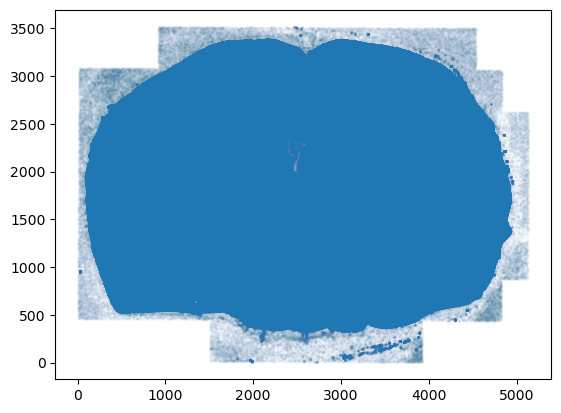

In [7]:
# df.x-=df.x.min()
# df.y-=df.y.min()

df.x/=um_per_pixel
df.y/=um_per_pixel

# df.x-=df.x.min()
# df.y-=df.y.min()

print(f'Pre-processing time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

plt.scatter(df.x,df.y,s=1,alpha=0.01)

In [8]:

perf_=time.perf_counter()

from src import ovrlp

perf_=time.perf_counter()

roi_df, distance_map, signal, divergence_map  = ovrlp.find_overlaps(df,threshold_fraction=0.5,density_weight=0.1,min_distance=4,min_expression=4.5,return_maps=True)

print(f'Ovrl.py runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

# re=run to compute divergence map:
# _, _, divergence, signal, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,
#                                             threshold_fraction=0.4,density_weight=0.1,
#                                             min_distance=20,return_maps=True)


Ovrl.py runtime: 366.14043173007667


#### Load snRNAseq data for cell typing:

In [9]:
import tqdm

# adata object with current celltype assignments:
adata_annotated_dapi = anndata.read_h5ad("/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/spatial/adata_multisection_nuclei_3rep_withHM_withclusters.h5ad")

adata_annotated_dapi = adata_annotated_dapi[adata_annotated_dapi.obs.replicate==str(n_replicate)]

cell_meta_df = adata_annotated_dapi.obs.copy()

celltypes = cell_meta_df.Class.cat.categories.tolist()

signatures = pd.DataFrame(index=adata_annotated_dapi.var.index, columns=celltypes)
signatures.iloc[:] = 0

for celltype in tqdm.tqdm(celltypes):
    signatures.loc[:,celltype] = list(adata_annotated_dapi[cell_meta_df.Class==celltype].X.mean(axis=0))

signatures = signatures.loc[genes,:]

color_series = pd.Series(adata_annotated_dapi.uns['Class_colors'],index=cell_meta_df.Class.cat.categories)

cell_meta_df.head()

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
  0%|                                                                                                                                                                          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_2920567/3352090601.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  signatures.loc[:,celltype] = list(adata_annotated_dapi[cell_meta_df.Class==celltype].X.mean(axis=0))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,replicate,...,leiden_2_2,leiden_1_4,leiden_0_6,X,Y,X_umap,Y_umap,dataset_source,nucleus_prop,Class
ind,,,,,,,,,,,,,,,,,,,,,
1,1,1557.532239,2528.022437,327,0,0,327,240.953750,63.038125,1,...,25,24,5,7329.559812,11896.570224,9.827806,7.383136,preview,0.261619,LA-BLA-BMA-PA Glut
2,2,1560.669312,2543.632678,354,0,0,354,211.692500,65.476562,1,...,54,14,14,7344.322500,11970.030148,5.984451,3.733681,preview,0.309300,Pvalb Gaba
3,3,1570.462885,2530.810461,422,0,0,422,186.946875,69.540625,1,...,25,24,5,7390.409879,11909.690334,9.747280,7.347030,preview,0.371981,LA-BLA-BMA-PA Glut
4,4,1573.927734,2546.454529,250,0,0,250,239.237812,61.728594,1,...,1,1,1,7406.715047,11983.309438,6.836078,-13.070249,preview,0.258022,Astrocytes
5,5,1581.344379,2557.024951,550,1,0,550,438.692969,92.209063,1,...,25,24,5,7441.616885,12033.052577,9.689524,7.293010,preview,0.210190,LA-BLA-BMA-PA Glut


In [23]:
import random

perf_=time.perf_counter()

random.seed(42)

vis = ovrlp.Visualizer(KDE_bandwidth=1,
                     celltyping_min_expression=5,
                    #    celltyping_min_distance=2,
                       n_components_pca=30,
                       cumap_kwargs={'n_neighbors':30,'min_dist':0,'metric':'euclidean','random_state':42})

vis.fit(df,signature_matrix=signatures)

print(f'SSAM/visualization runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

vis.plot_fit()

In [ ]:
def compute_divergence_embedded(df,genes,visualizer, KDE_bandwidth, min_expression,):

    signal = create_histogram(df, vis ,x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=KDE_bandwidth)   

    genes = vis.genes    

    pca = PCA(0.8)

    facs = pca.fit_transform(vis.localmax_celltyping_samples.T)

    mask = signal>min_expression

    df_top = df[df.z_delim < df.z]
    df_bot = df[df.z_delim > df.z]

    # dr_bottom = np.zeros((df_bottom.shape[0],df_bottom.shape[1], pca.components_.shape[0]))
    # dr_top = np.zeros((df_bottom.shape[0],df_bottom.shape[1], pca.components_.shape[0]))

    hists_top = np.zeros((mask.sum(),pca.components_.shape[0],))
    hists_bot = np.zeros((mask.sum(),pca.components_.shape[0],))

    # hists_top = np.zeros((mask.sum(),len(genes),))
    # hists_bot = np.zeros((mask.sum(),len(genes),))


    distance = np.zeros((signal.shape[0],signal.shape[1],pca.components_.shape[0]))#((np.ceil(df[['x_pixel','y_pixel']].max())).astype(int)+1)

    for i,g in tqdm.tqdm(enumerate(vis.genes)):

        if np.abs(pca.components_.std(0)[i]) < 0.001:
            continue

        hist_top = np.dot(ovrlp.create_histogram(df_top, genes=[g],x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=1.0)[mask][:,None], pca.components_[None,:,i])
        hist_bot = np.dot(ovrlp.create_histogram(df_bot, genes=[g],x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=1.0)[mask][:,None], pca.components_[None,:,i])

        hists_top+=hist_top
        hists_bot+=hist_bot

    # Cosine similarity:
    hists_top_norm = hists_top / np.linalg.norm(hists_top, axis=1)[:, None]
    hists_bot_norm = hists_bot / np.linalg.norm(hists_bot, axis=1)[:, None]

    cos_sim = (hists_top_norm*hists_bot_norm).sum(axis=1)

    distance_ = np.zeros_like(signal)
    distance_[mask] = cos_sim

    return distance_

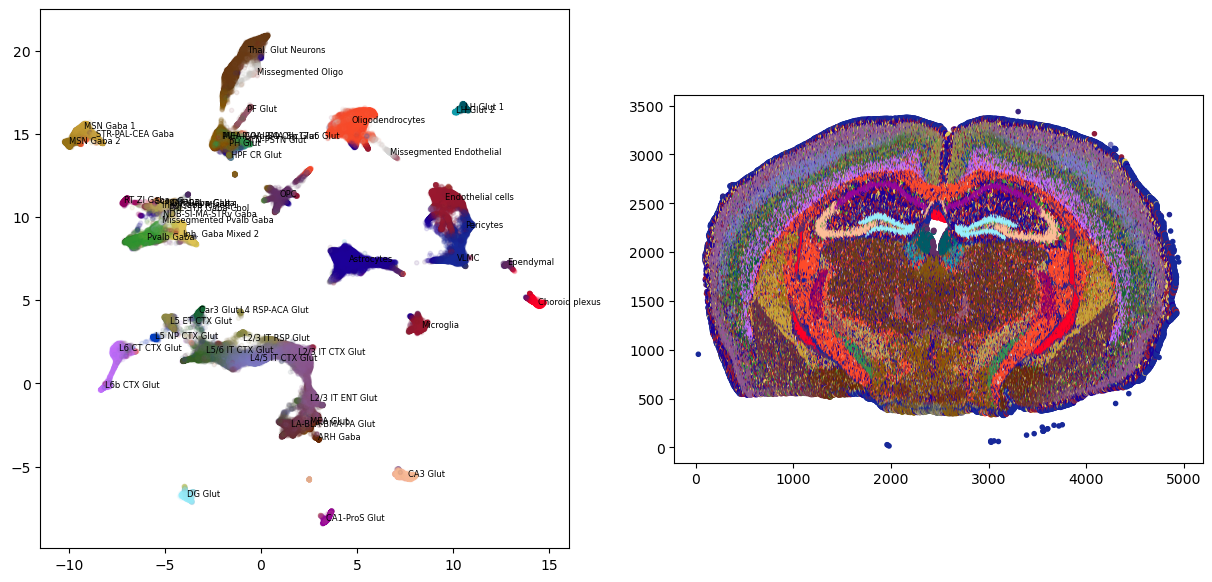

In [ ]:
color_matrix = np.vstack(color_series.map(lambda x: np.array([int(x[1:3],16)/255,int(x[3:5],16)/255,int(x[5:7],16)/255])).values)

correlations = np.array([np.corrcoef(vis.localmax_celltyping_samples.iloc[:,i],signatures.values.T)[0,1:] for i in range(vis.localmax_celltyping_samples.shape[1])])
correlations

correlations_ = correlations.copy()

# take the softmax of correlations along axis 1:

correlations_[correlations_<0]=0    
correlations_ = correlations_**15
correlations_ = correlations_/correlations_.sum(axis=1)[:,None]
colors_remixed = np.dot(correlations_,color_matrix)

vis.colors=colors_remixed

vis.plot_fit()

In [ ]:

# # import pandas as pd
boudary_path = f"/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/replicate{n_replicate}/"
cell_boundaries = pd.read_csv(os.path.join(boudary_path,'nucleus_boundaries.csv'))
cell_boundaries.vertex_x/=um_per_pixel
cell_boundaries.vertex_y/=um_per_pixel

# # # xenium_cluster_assignments = pd.read_csv('/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/replicate2/analysis/clustering/gene_expression_graphclust/clusters.csv',index_col=0)

# # plt.scatter()


In [ ]:
import tqdm
from sklearn.decomposition import PCA

pca = PCA(0.8)

facs = pca.fit_transform(vis.localmax_celltyping_samples.T)

mask = signal>2

df_top = df[df.z_delim < df.z]
df_bot = df[df.z_delim > df.z]

# dr_bottom = np.zeros((df_bottom.shape[0],df_bottom.shape[1], pca.components_.shape[0]))
# dr_top = np.zeros((df_bottom.shape[0],df_bottom.shape[1], pca.components_.shape[0]))

hists_top = np.zeros((mask.sum(),pca.components_.shape[0],))
hists_bot = np.zeros((mask.sum(),pca.components_.shape[0],))

# hists_top = np.zeros((mask.sum(),len(genes),))
# hists_bot = np.zeros((mask.sum(),len(genes),))


distance = np.zeros((signal.shape[0],signal.shape[1],pca.components_.shape[0]))#((np.ceil(df[['x_pixel','y_pixel']].max())).astype(int)+1)

for i,g in tqdm.tqdm(enumerate(vis.genes)):

    if np.abs(pca.components_.std(0)[i]) < 0.001:
        continue

    hist_top = np.dot(ovrlp.create_histogram(df_top, genes=[g],x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=1.0)[mask][:,None], pca.components_[None,:,i])
    hist_bot = np.dot(ovrlp.create_histogram(df_bot, genes=[g],x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=1.0)[mask][:,None], pca.components_[None,:,i])

    hists_top+=hist_top
    hists_bot+=hist_bot

    # break

    # plt.imshow()

    # distance[mask] += (hist_top-hist_bot)
    # break

# distance = (distance)
# plt.imshow(distance, cmap='hot', interpolation='nearest')


248it [17:08,  4.15s/it]


In [ ]:
# draw outlines around artist:
import matplotlib.patheffects as PathEffects
 

def draw_outline(ax, artist, lw=2,color='black'):
    path = artist.set_path_effects([PathEffects.withStroke(linewidth=lw, foreground=color), PathEffects.Normal()])

def plot_scalebar(ax,x,y,length=100,fontsize=10,text='100um',color='k',text_offset=0,edge_color=None):
    plot_artist = ax.plot([x,x+length],[y,y],c=color,lw=2)
    text_artist = ax.text(x+length/2,y+text_offset,text,fontsize=fontsize,ha='center',va='bottom',c=color)

    if edge_color is not None:
        draw_outline(ax,plot_artist[0],lw=5,color=edge_color)
        draw_outline(ax,text_artist,lw=5,color=edge_color)

    return plot_artist, text_artist

In [ ]:
signal_ = ovrlp.create_histogram(df, genes=vis.genes,x_max=df.x_pixel.max(),y_max=df.y_pixel.max(),KDE_bandwidth=1.0)

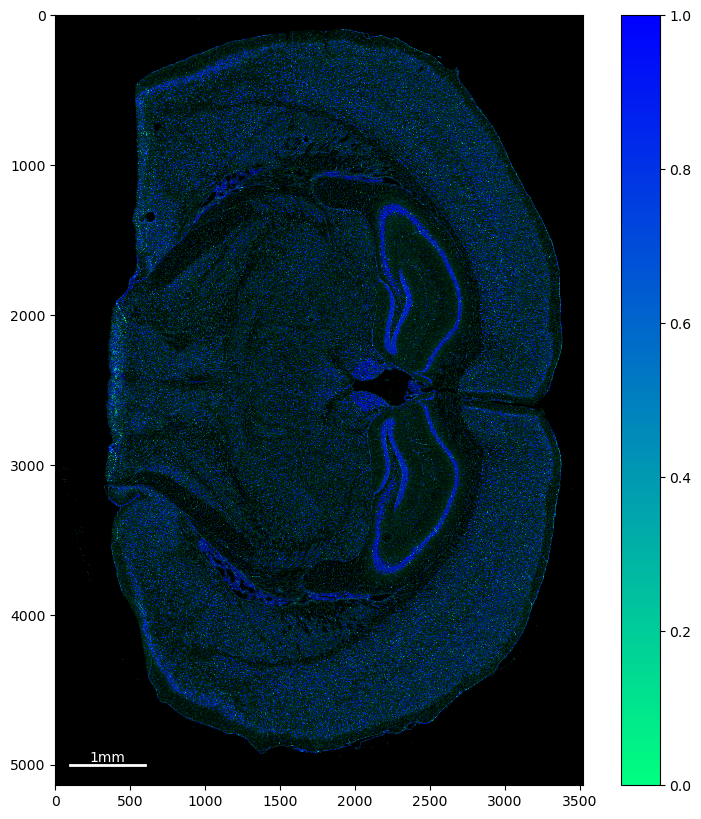

In [ ]:
# Cosine similarity:
hists_top_norm = hists_top / np.linalg.norm(hists_top, axis=1)[:, None]
hists_bot_norm = hists_bot / np.linalg.norm(hists_bot, axis=1)[:, None]

cos_sim = (hists_top_norm*hists_bot_norm).sum(axis=1)

# Plotting:
distance_ = np.zeros_like(signal)
distance_[mask] = cos_sim

# distance__ = np.zeros_like(signal)
# distance__[mask] = 1/(1+cos_sim)
distance = ovrlp.gaussian_filter(distance_,sigma=1)

plt.figure(figsize=(10, 10))

ax = plt.subplot(111,facecolor='k')

signal__ = signal_.copy()
signal__ [signal__>20]=20

plt.imshow(distance_, cmap='winter_r', vmin= 0.0, vmax=1.0, alpha = signal__/20, interpolation='nearest')

plt.colorbar()
plot_scalebar(ax,100,5000,500,text='1mm',color='w',edge_color=None)


plt.savefig(f'./output/figures-xenium-brain/replicate{n_replicate}_heatmap.png',dpi=300)
plt.savefig(f'./output/figures-xenium-brain/replicate{n_replicate}_heatmap.pdf',dpi=300)


In [ ]:

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(vis.embedding)
ct_color_matrix = pd.DataFrame(index=signatures.columns, columns = ['r','g','b'], dtype=float)
gene_color_matrix = pd.DataFrame(index=vis.genes, columns = ['r','g','b'], dtype=float)

for i,c in enumerate(color_matrix):

    ct_color_matrix.iloc[i,:] = c

for i,g in enumerate(vis.genes):

    cog = vis.gene_centers[i]

    if not np.isnan(cog[0]):

        dist, ind = nbrs.kneighbors([cog])
        ind=ind[0][0]

        rgb = vis.colors[ind]

        gene_color_matrix.loc[g,:] = rgb

        

# ct_color_matrix.to_csv('./celltype_colors.csv')

In [ ]:
#Is generated at the end of the notebook

cell_area_incoherence_data = pd.read_csv("./output/intermediates-xenium-brain/area_incoherence_slice_1.csv")

/tmp/ipykernel_2902777/4082878428.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_area_incoherence_data = pd.read_csv("./output/intermediates-xenium-brain/area_incoherence_slice_1.csv")


In [ ]:

distance__ = ovrlp.gaussian_filter(distance_,0.5)
dist_x,dist_y,dist_t = ovrlp.determine_localmax((distance__), min_distance=7, min_expression=(distance__).max()*0.1)

arg_idcs = np.argsort(dist_t)[::-1]
dist_x,dist_y = dist_x[arg_idcs], dist_y[arg_idcs]

Text(0.5, 0.92, '0')

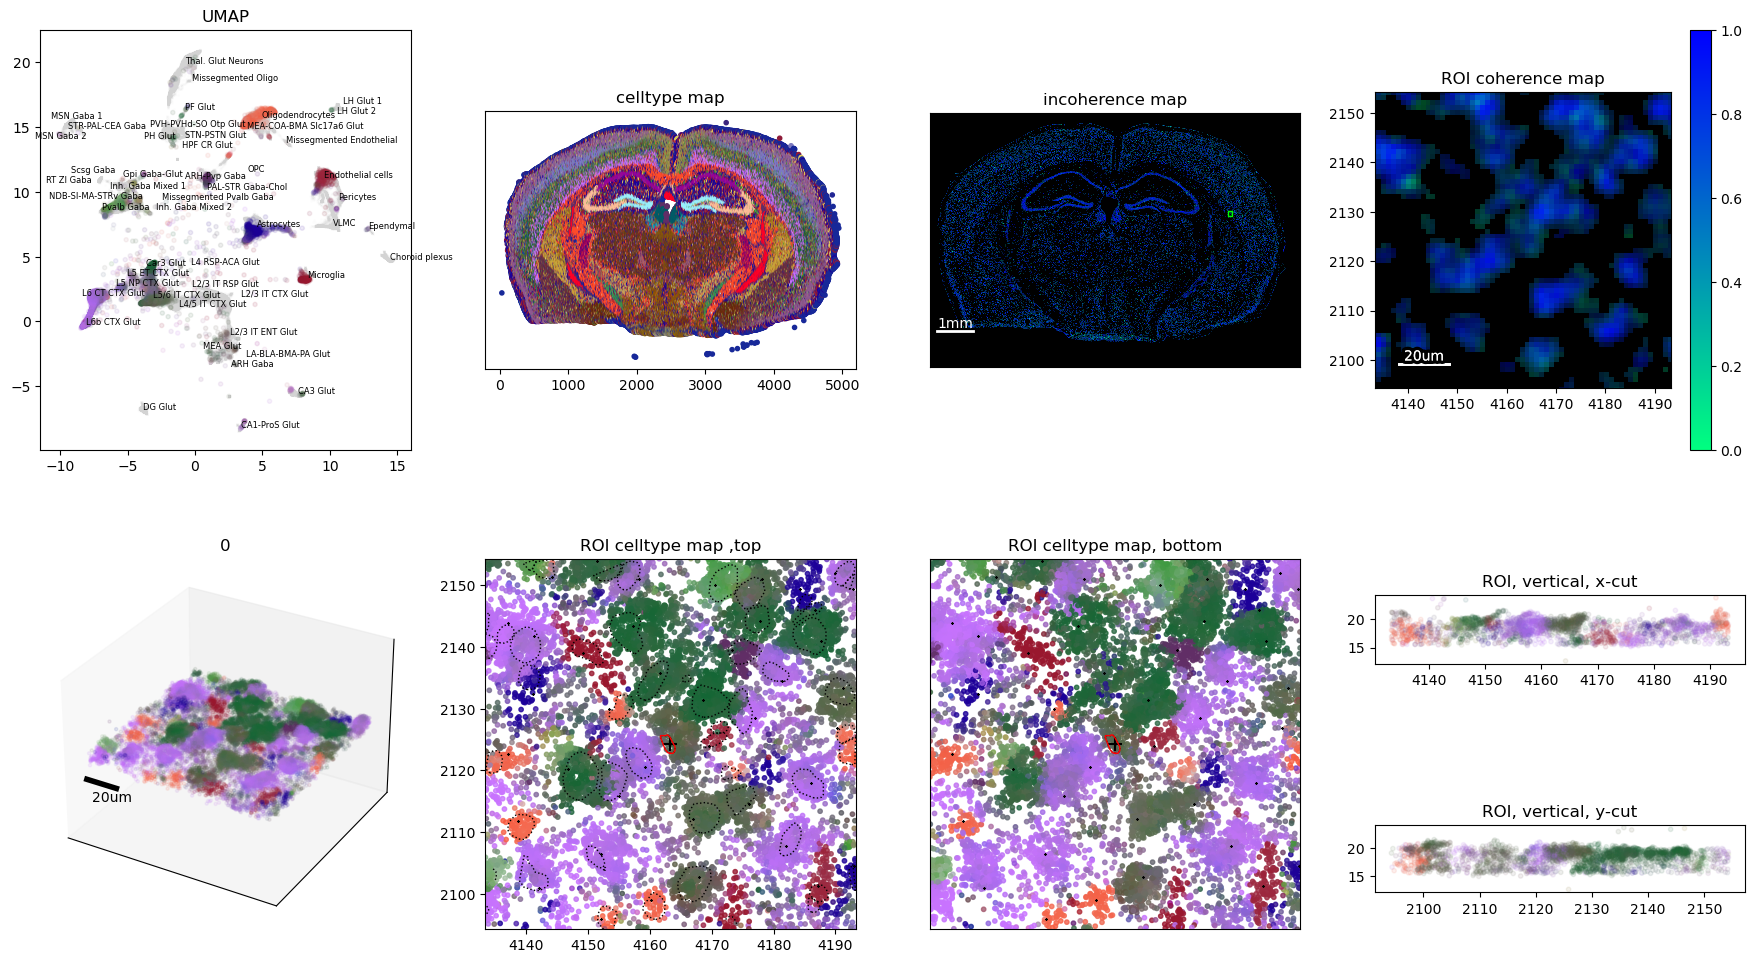

In [ ]:
import matplotlib.patches as patches
# import TrRd:
# from matplotlib.cm import TrRd

# n = np.argsort(cell_area_incoherence_data.incoherence_mean)[2010]

# n= (coherence_at_centroids_index[signal_at_centroids>8])[-20]

window_size = 30

random.seed(42)

signal__ = signal_.copy()
signal__ [signal__>20]=20
signal__[signal__<5]=0
signal__/=signal__.max()

x,y = roi_df[['x','y']].iloc[0].values
# x,y = dist_x[n],dist_y[n]
# x = cell_meta_df.x_centroid.iloc[n]/um_per_pixel
# y = cell_meta_df.y_centroid.iloc[n]/um_per_pixel

subsample, subsample_embedding, subsample_embedding_color = vis.transform(x,y,df)

distances, neighbor_indices = ovrlp.create_knn_graph(subsample[['x','y','z']].values,k=90)
local_expression = ovrlp.get_knn_expression(distances,neighbor_indices,genes,subsample.gene.cat.codes.values,bandwidth=1.0)
local_expression = local_expression/((local_expression**2).sum(0)**0.5)

correlations = np.array([np.corrcoef(local_expression.iloc[:,i],signatures.values.T)[0,1:] for i in range(local_expression.shape[1])])
correlations

correlations_ = correlations.copy()
correlations_[correlations_<0]=0    
correlations_ = correlations_**7
correlations_ = correlations_/correlations_.sum(axis=1)[:,None]
subsample_embedding_color = np.dot(correlations_,color_matrix)

vis.plot_instance(subsample,subsample_embedding,subsample_embedding_color,x,y,window_size=window_size,rasterized=True)

# print(f'instance visualization runtime: {time.perf_counter()-perf_}')

fig = plt.gcf()
gs = (fig.get_axes()[0]).get_gridspec()

# Create a Rectangle patch
# rect = patches.Rectangle((x-window_size, y-window_size), window_size*2, window_size*2, linewidth=1, edgecolor='k', facecolor='none')
# ax.add_patch(rect)

ax =  fig.add_subplot(gs[0,2], facecolor='k')
ax.set_title('incoherence map')
# handle_signal = ax.imshow(signal.T<1,cmap="Greys",alpha=0.1)
# handle_divergence = ax.imshow(distance__.T,cmap='Reds', alpha=(signal.T>0.5).astype(float))
ax.imshow(distance_.T, cmap='winter_r', vmin= 0.0, vmax=1.0, alpha = signal__.T, interpolation='nearest')

ax.invert_yaxis()
plot_scalebar(ax,100,500,500,text='1mm',color='w',edge_color=None)
ax.set_xticks([])
ax.set_yticks([])

# Create a Rectangle patch
rect = patches.Rectangle((x-window_size, y-window_size), window_size*2, window_size*2, linewidth=1, edgecolor='lime', facecolor='none')
ax.add_patch(rect)

ax = fig.add_subplot(gs[0,3], facecolor='k')
ax.set_title('ROI coherence map')
# handle_signal = ax.imshow(signal.T<1,cmap="Greys",alpha=0.1)
# handle_divergence = ax.imshow(distance__.T,cmap='Reds', alpha=(signal.T>0.5).astype(float))
# handle_signal = signal_ [signal_>3]=3

# ax.imshow(distance.T, cmap='autumn_r', vmin= 0.2, vmax=1, alpha = signal_.T/3, interpolation='nearest')
plt.imshow(distance_.T, cmap='winter_r', vmin= 0.0, vmax=1.0, alpha = signal__.T, interpolation='nearest')
plot_scalebar(ax,x-window_size+5,y-window_size+5,10,text='20um',color='w',edge_color='k')

cell_boundaries_subset = cell_boundaries[(cell_boundaries.vertex_x>(x-window_size))&\
                                    (cell_boundaries.vertex_x<(x+window_size))&\
                                    (cell_boundaries.vertex_y>(y-window_size))&\
                                        (cell_boundaries.vertex_y<(y+window_size))]

centroid_subset = cell_meta_df[((cell_meta_df.x_centroid/um_per_pixel)>(x-window_size))&((cell_meta_df.x_centroid/um_per_pixel)<(x+window_size))&(cell_meta_df.y_centroid/um_per_pixel>(y-window_size))&(cell_meta_df.y_centroid/um_per_pixel<(y+window_size))]

for j in [3,4]:
    ax = fig.get_axes()[j]
    for i,c in enumerate(cell_boundaries_subset.cell_id.unique()):
        edge_color = 'k'
        ax.plot(cell_boundaries_subset[cell_boundaries_subset.cell_id==c].vertex_x,
                    cell_boundaries_subset[cell_boundaries_subset.cell_id==c].vertex_y,
                    c=edge_color,linestyle=':',linewidth=1)

    cell_boundaries_subset = cell_boundaries[cell_boundaries.cell_id==cell_meta_df.iloc[n].cell_id]

    ax.plot(cell_boundaries_subset.vertex_x,cell_boundaries_subset.vertex_y,c='r',linewidth=1)

    ax.scatter(centroid_subset.x_centroid/um_per_pixel,centroid_subset.y_centroid/um_per_pixel,c='k',s=1,marker='x')


plt.colorbar()

plt.xlim(x-window_size,x+window_size)
plt.ylim(y-window_size,y+window_size) 
ax.set_xticks([])
ax.set_yticks([])
# ax.invert_yaxis()

# # Create a Rectangle patch
# plt.savefig(f'./output/figures-xenium-brain/{n}.png',dpi=300)
# plt.savefig(f'./output/figures-xenium-brain/{n}.pdf',dpi=300)
# plt.savefig(f'./output/figures-xenium-brain/{n}.svg',dpi=300)
   
scalebar_z_position = subsample.z.min()

ax = fig.get_axes()[0]
line_artist = ax.plot([x-window_size,x-window_size+10],[y-window_size,y-window_size],[scalebar_z_position,scalebar_z_position],c='k',lw=4)
text_artist = ax.text(x-window_size+5,y-window_size+5,scalebar_z_position-6,'20um',fontsize=10,ha='center',va='top',c='k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_title('0')


0.01824940031190774


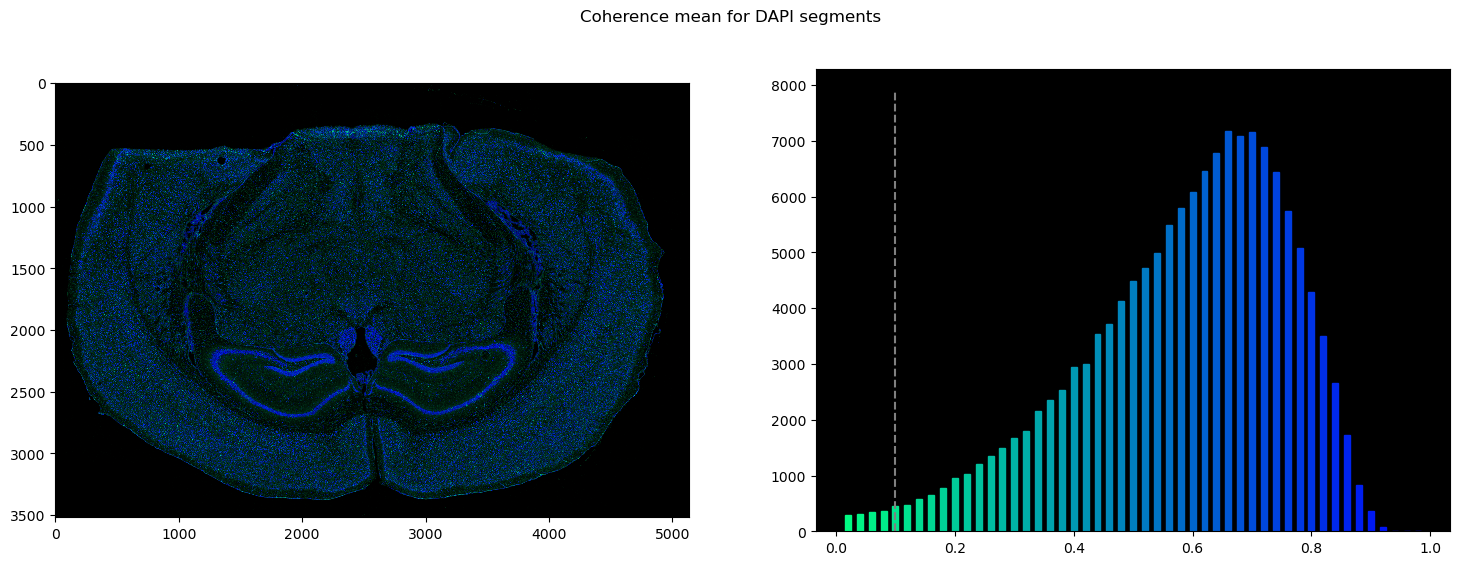

In [ ]:
import scipy
from matplotlib.cm import winter_r

fig = plt.figure(figsize=(18,6))

plt.suptitle('Coherence mean for DAPI segments')

ax = fig.add_subplot(121,facecolor='k')

signal__ = signal_.copy()
signal__ [signal__>20]=20
signal__/=20

ax.imshow(distance_.T, cmap='winter_r', vmin= 0, vmax=1.0, alpha = signal__.T, interpolation='nearest')

coherence_at_area = cell_area_incoherence_data.incoherence_mean

coherence_at_area_index = np.argsort(coherence_at_area)[::-1]

ax1 = fig.add_subplot(122,facecolor='k')

vals,bins = np.histogram(coherence_at_area, bins=50, range=(0,1))
colors = winter_r(bins[1:-1])
bars = ax1.bar(bins[1:-1],vals[1:],width=0.01)

for i,bar in enumerate(bars):
    bar.set_color(colors[i])

plt.vlines(0.1,0,vals.max()*1.1,colors='grey',linestyles='--')

print((coherence_at_area<0.2).mean())

In [ ]:
Do you want to continue? [y/n]

from shapely.geometry import Polygon as shapely_Polygon
from shapely.geometry import  Point
import tqdm

cell_area_incoherence_data = pd.DataFrame(index=cell_meta_df,columns=['area','incoherence_mean','incoherence_max','incoherence_median'],dtype=float)


def contains(sh_polygon, coords):
    return sh_polygon.contains(Point(coords))

segmentation_map = np.zeros(np.ceil(cell_boundaries[['vertex_x','vertex_y']].max()).astype(int),dtype=np.uint32)

for i,idx in tqdm.tqdm(enumerate(cell_meta_df.index.astype(int))):

    # print(i,cell_meta_df.loc[idx])


    coords = cell_boundaries[cell_boundaries.cell_id==idx][['vertex_x','vertex_y']].values
    sh_polygon = shapely_Polygon(coords)

    mins_ = np.floor(coords.min(0))
    maxs_ = np.ceil(coords.max(0))

    X,Y = np.meshgrid(np.arange(mins_[0],maxs_[0]),np.arange(mins_[1],maxs_[1]))
    points = np.vstack([X.ravel(),Y.ravel()]).T.astype(np.uint32)



    distance_subset = (distance_[points[:,0],points[:,1]])

    segmentation_map[points[:,0],points[:,1]] = i+1

    cell_area_incoherence_data.loc[idx,'area'] = sh_polygon.area
    cell_area_incoherence_data.loc[idx,'incoherence_mean'] = distance_subset.mean()
    cell_area_incoherence_data.loc[idx,'incoherence_max'] = distance_subset.max()
    cell_area_incoherence_data.loc[idx,'incoherence_median'] = np.median(distance_subset)

    print(cell_area_incoherence_data)

    break

NameError: name 'pd' is not defined

In [ ]:
from shapely.geometry import Polygon as shapely_Polygon
from shapely.geometry import  Point
import tqdm


cell_area_incoherence_data = pd.DataFrame(index=adata_snrna_vizgen.obs.cell_id.values,columns=['area','incoherence_mean','incoherence_max'],dtype=float)


def contains(sh_polygon, coords):
    return sh_polygon.contains(Point(coords))

segmentation_map = np.zeros(np.ceil(cell_boundaries[['vertex_x','vertex_y']].max()).astype(int),dtype=np.uint32)

for i,idx in tqdm.tqdm(enumerate(adata_snrna_vizgen.obs.cell_id.values),total = len(adata_snrna_vizgen.obs)):
    
    coords = cell_boundaries[cell_boundaries.cell_id==idx][['vertex_x','vertex_y']].values
    sh_polygon = shapely_Polygon(coords)

    mins_ = np.floor(coords.min(0))
    maxs_ = np.ceil(coords.max(0))

    X,Y = np.meshgrid(np.arange(mins_[0],maxs_[0]),np.arange(mins_[1],maxs_[1]))
    points = np.vstack([X.ravel(),Y.ravel()]).T.astype(np.uint32)

    out = np.zeros((len(points),),dtype=bool)

    for j,point in enumerate(points):
        out[j] = contains(sh_polygon, point)

    points = points[out]
    segmentation_map[points[:,0],points[:,1]] = idx


    out = np.zeros((len(points),),dtype=bool)

    for j,point in enumerate(points):
        out[j] = contains(sh_polygon, point)

    points = points[out]
    segmentation_map[points[:,0],points[:,1]] = i+1

    cell_area_incoherence_data.loc[idx,'area'] = len(points)
    # cell_area_divergence_data.loc[idx,'area'] = len(points)

    if len(points)>0:
              
        cell_area_incoherence_data.loc[i+1,'incoherence_mean'] = incoherence[points[:,0],points[:,1]].mean()
        cell_area_incoherence_data.loc[i+1,'incoherence_max'] = incoherence[points[:,0],points[:,1]].max()
        cell_area_incoherence_data.loc[i+1,'incoherence_median'] = np.median(incoherence[points[:,0],points[:,1]])

        cell_area_incoherence_data.loc[i+1,'divergence_mean'] = divergence_map[points[:,0],points[:,1]].mean()
        cell_area_incoherence_data.loc[i+1,'divergence_max'] = divergence_map[points[:,0],points[:,1]].max()
        cell_area_incoherence_data.loc[i+1,'divergence_median'] = np.median(divergence_map[points[:,0],points[:,1]])

cell_area_incoherence_data = cell_area_incoherence_data.replace(np.NINF,0)
cell_area_incoherence_data = cell_area_incoherence_data.fillna(0)
# cell_area_divergence_data = cell_area_divergence_data.replace(np.NINF,0)
cell_area_incoherence_data['leiden'] = adata_snrna_vizgen.obs.leiden.values #Exenium_cluster_assignments.Cluster 

# cell_area_divergence_data['celltype'] = adata_snrna_vizgen.obs.cell_type.values
cell_area_incoherence_data['celltype'] = adata_snrna_vizgen.obs.cell_type.values
cell_area_incoherence_data.to_csv(f'./output/intermediates-xenium-brain/area_incoherence_slice_{n_replicate}.csv')